<a href="https://colab.research.google.com/github/architb1703/Toxic_Span/blob/Abhay/xlnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchtext import data

In [ ]:

!pip install transformers==2.6.0
!pip install seqeval
!pip install urllib3 --upgrade

     |████████████████████████████████| 542kB 9.3MB/s 
     |████████████████████████████████| 3.7MB 16.0MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
     |████████████████████████████████| 1.1MB 49.6MB/s 
     |████████████████████████████████| 133kB 55.8MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 6.8MB 57.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cbad80042e5d2ccb5558f5a8c6f8e4b6f82cd9b631648177b8fa5c97522df2be
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.20 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=54a26ea3bae1986c0a304a413824

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/'My Drive'

/content/gdrive/My Drive


In [ ]:
print(torch.__version__)

1.6.0+cu101


In [ ]:
|

Mounted at /content/gdrive


In [ ]:
train_path = '/content/drive/MyDrive/ToxicSpan_CS669V/processed/finaltrain.pkl'
val_path = '/content/drive/MyDrive/ToxicSpan_CS669V/processed/finaldev.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
with open(train_path, 'rb') as f:
  train_data = pickle.load(f)
  f.close()

with open(val_path, 'rb') as f:
  val_data = pickle.load(f)
  f.close()

In [ ]:
import transformers
from transformers import  XLNetTokenizer, XLNetForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from seqeval.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
X_train = train_data['token_final']
X_val = val_data['token_final']
Y_train = train_data['target_final']
Y_val = val_data['target_final']

In [ ]:
MAX_LEN = 300
BATCH_SIZE = 16

In [ ]:

### tokenizer

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case = False)

In [ ]:
def tokenize_xlnet(x, y):
  sentence = []
  labels = []
  for word, label in zip(x, y):
    tokenized_word = tokenizer.tokenize(word)
    sentence.extend(tokenized_word)
    labels.extend([label for i in range(len(tokenized_word))])
  return(sentence, labels)

def tokenize_xlnet(x, y):
  sentence = []
  labels = []
  for word, label in zip(x, y):
    tokenized_word = tokenizer.tokenize(word)
    sentence.extend(tokenized_word)
    labels.extend([label for i in range(len(tokenized_word))])
  return(sentence, labels)


len_train = len(X_train)
len_val = len(X_val)

for i in range(len_train):
  X_train[i], Y_train[i] = tokenize_xlnet(X_train[i], Y_train[i])

for i in range(len_val):
  X_val[i], Y_val[i] = tokenize_xlnet(X_val[i], Y_val[i])

In [ ]:
CLASSES = {'0':0, '1':1, '[PAD]':2}

In [ ]:
ones = 0
zeros = 0
total = 0
for y in Y_train:
  ones += np.sum(np.array(y))
  zeros += len(y) - np.sum(np.array(y))
  total += len(y)
for y in Y_val:
  ones += np.sum(np.array(y))
  zeros += len(y) - np.sum(np.array(y))
  total += len(y)
# print(ones, zeros)
class_weights = torch.tensor([zeros/zeros, zeros/ones], dtype=torch.float32)

In [ ]:
X_train_id = pad_sequences([tokenizer.convert_tokens_to_ids(text) for text in X_train], maxlen = MAX_LEN, dtype='long', value=0.0, truncating='post', padding = 'post')
Y_train_id = pad_sequences(Y_train, maxlen=MAX_LEN, value=CLASSES['[PAD]'], dtype='long', truncating='post', padding='post')
X_val_id = pad_sequences([tokenizer.convert_tokens_to_ids(text) for text in X_val], maxlen = MAX_LEN, dtype='long', value=0.0, truncating='post', padding = 'post')
Y_val_id = pad_sequences(Y_val, maxlen=MAX_LEN, value=CLASSES['[PAD]'], dtype='long', truncating='post', padding='post')



X_train_id = pad_sequences([tokenizer.convert_tokens_to_ids(text) for text in X_train], maxlen = MAX_LEN, dtype='long', value=0.0, truncating='post', padding = 'post')
Y_train_id = pad_sequences(Y_train, maxlen=MAX_LEN, value=CLASSES['[PAD]'], dtype='long', truncating='post', padding='post')
X_val_id = pad_sequences([tokenizer.convert_tokens_to_ids(text) for text in X_val], maxlen = MAX_LEN, dtype='long', value=0.0, truncating='post', padding = 'post')
Y_val_id = pad_sequences(Y_val, maxlen=MAX_LEN, value=CLASSES['[PAD]'], dtype='long', truncating='post', padding='post')

In [ ]:
X_train[0]

['▁only',
 '▁a',
 '▁fool',
 '▁would',
 '▁not',
 '▁be',
 '▁against',
 '▁this',
 '▁president',
 '▁he',
 '▁is',
 '▁massive',
 'ly',
 '▁and',
 '▁obviously',
 '▁unfit',
 '▁for',
 '▁office']

In [ ]:
def get_attention_mask(x):
  return([[int(i!=0) for i in text] for text in x])

In [ ]:
attention_mask_train = get_attention_mask(X_train_id)
attention_mask_val = get_attention_mask(X_val_id)

In [ ]:
X_train_id = torch.tensor(X_train_id)
Y_train_id = torch.tensor(Y_train_id)
X_val_id = torch.tensor(X_val_id)
Y_val_id = torch.tensor(Y_val_id)
attention_mask_train = torch.tensor(attention_mask_train)
attention_mask_val = torch.tensor(attention_mask_val)

In [ ]:
train_data = TensorDataset(X_train_id, attention_mask_train, Y_train_id)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(X_val_id, attention_mask_val, Y_val_id)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

In [ ]:
model = XLNetForTokenClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

In [ ]:
model.cuda()

XLNetForTokenClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
FINE_TUNING = True
if FINE_TUNING:
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
                                  {'params' : [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate' : 0.01},
                                  {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]
else:
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=1e-8)

In [ ]:
epochs = 3
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

In [ ]:
def get_text_lengths(masks):
  lengths = []
  for mask in masks:
    lengths.append(torch.sum(mask).item())
  return(lengths)

In [ ]:
train_loss, val_loss = [], []
train_acc, val_acc = [], []
train_f1, val_f1 = [], []

l = 100

for epoch in trange(epochs, desc = 'Epoch'):
  print(epoch)
  model.train()
  t_loss, t_acc = 0, 0
  predictions, true_labels = [], []
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_id, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_id, token_type_ids=None, attention_mask=b_input_mask, labels = b_labels)
    active_loss = b_input_mask.view(-1) == 1
    active_logits = outputs[1].view(-1, 2)
    active_labels = torch.where(active_loss, b_labels.view(-1), torch.tensor(criterion.ignore_index).type_as(b_labels))
    loss = criterion(active_logits, active_labels)
    loss.backward()
    t_loss += loss.item()
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    optimizer.step()
    scheduler.step()

    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)
    
  print(f"Train Loss : {t_loss/len(train_dataloader)}")
  train_loss.append(t_loss/len(train_dataloader))
  pred_tags = [p_i for p, l in zip(predictions, true_labels)
                                for p_i, l_i in zip(p, l) if l_i != 2]
  valid_tags = [l_i for l in true_labels
                                for l_i in l if l_i != 2]
  train_acc.append(accuracy_score(pred_tags, valid_tags))
  train_f1.append(f1_score(pred_tags, valid_tags))
  print("Train Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
  print("Train F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
  print()

  model.eval()
  v_loss, v_accuracy = 0, 0
  predictions , true_labels = [], []
  for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_id, b_input_mask, b_labels = batch
    with torch.no_grad():
      outputs = model(b_input_id, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    
    active_loss = b_input_mask.view(-1) == 1
    active_logits = outputs[1].view(-1, 2)
    active_labels = torch.where(active_loss, b_labels.view(-1), torch.tensor(criterion.ignore_index).type_as(b_labels))
    loss = criterion(active_logits, active_labels)
    
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    v_loss += loss.item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)
  
  v_loss = v_loss/len(val_dataloader)
  val_loss.append(v_loss)
  # if(v_loss < l):
  #   l = v_loss
  #   print("Model Checkpoint")
  #   torch.save(model, f'./savedmodel/xlnet-{epoch}.pt')
    
  print(f"Validation Loss : {v_loss}")
  pred_tags = [p_i for p, l in zip(predictions, true_labels)
                                for p_i, l_i in zip(p, l) if l_i != 2]
  valid_tags = [l_i for l in true_labels
                                for l_i in l if l_i != 2]
  print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
  print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
  val_acc.append(accuracy_score(pred_tags, valid_tags))
  val_f1.append(f1_score(pred_tags, valid_tags))
  print()



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

0
Train Loss : 0.4101155152173727
Train Accuracy: 0.8773180876739528
Train F1-Score: 0.5130978260869565

Validation Loss : 0.7028064116835594




Epoch:  33%|███▎      | 1/3 [10:39<21:18, 639.22s/it]

Validation Accuracy: 0.8764228099266462
Validation F1-Score: 0.4734762303915699

1
Train Loss : 0.2880036531752843
Train Accuracy: 0.9071772136731655
Train F1-Score: 0.6172177203038088

Validation Loss : 0.6900150856375694




Epoch:  67%|██████▋   | 2/3 [21:17<10:38, 638.91s/it]

Validation Accuracy: 0.8650403305134763
Validation F1-Score: 0.45555555555555555

2
Train Loss : 0.20077142022756544
Train Accuracy: 0.9323120110919019
Train F1-Score: 0.7056949778214403

Validation Loss : 0.9350596261024475




Epoch: 100%|██████████| 3/3 [31:55<00:00, 638.60s/it]

Validation Accuracy: 0.8900817852224502
Validation F1-Score: 0.48287716514610607



In [ ]:
torch --version

NameError: ignored

In [ ]:
torch.save(model, './savedmodels/xlnet3epochs.pt')

In [ ]:
cd Toxic\ Spam

/content/gdrive/My Drive/Toxic Spam


In [ ]:
ls

Attention-Improved-LSTM.ipynb  LSTM.ipynb     test_split.csv   xlnet2.ipynb
final.pkl                      processed/     train.json       xlnet.ipynb
Ibilstm1.pt                    processed.csv  train_split.csv
Improved-LSTM.ipynb            Roberta.ipynb  val.json
losses1.json                   savedmodels/   val_split.csv


[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')]

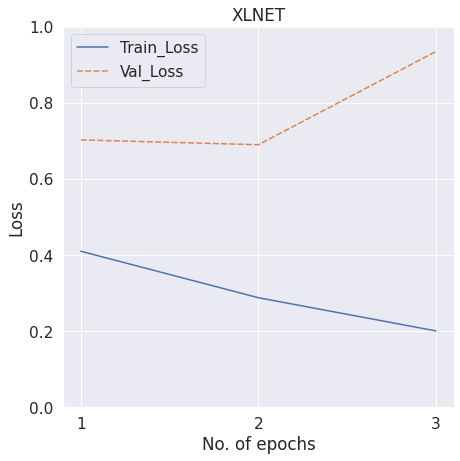

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
epoch=[]
for i in range(3):
    epoch.append(i+1)
sns.set(font_scale=1.4)

plt.figure(figsize=(7,7))
dic={'Train_Loss':train_loss,'Val_Loss': val_loss}
x=pd.DataFrame(dic)
ax = sns.lineplot(data=x)
ax.set(ylim=(0,1),xlabel='No. of epochs',ylabel='Loss',title='XLNET')
ax.set_xticks(range(3)) # <--- s
ax.set_xticklabels(['1','2','3'])

[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')]

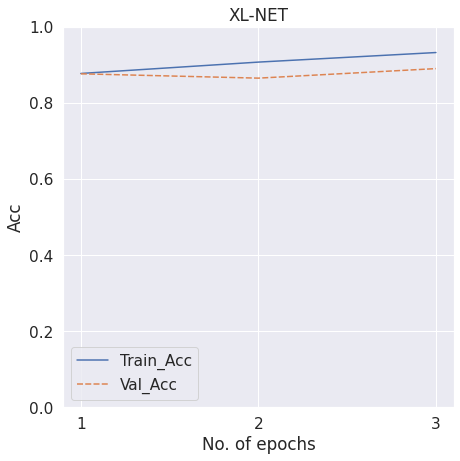

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
epoch=[]
for i in range(3):
    epoch.append(i+1)
sns.set(font_scale=1.4)

plt.figure(figsize=(7,7))
dic={'Train_Acc':train_acc,'Val_Acc': val_acc}
x=pd.DataFrame(dic)
ax = sns.lineplot(data=x)
ax.set(ylim=(0,1),xlabel='No. of epochs',ylabel='Acc',title='XL-NET')
ax.set_xticks(range(3)) # <--- s
ax.set_xticklabels(['1','2','3'])

[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')]

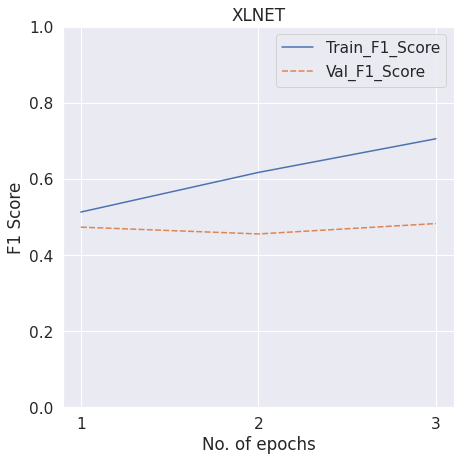

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
epoch=[]
for i in range(3):
    epoch.append(i+1)
sns.set(font_scale=1.4)

plt.figure(figsize=(7,7))
dic={'Train_F1_Score':train_f1,'Val_F1_Score': val_f1}
x=pd.DataFrame(dic)
ax = sns.lineplot(data=x)
ax.set(ylim=(0,1),xlabel='No. of epochs',ylabel='F1 Score',title='XLNET')
ax.set_xticks(range(3)) # <--- s
ax.set_xticklabels(['1','2','3'])